### <b>Restricted Boltzmann Machines</b>

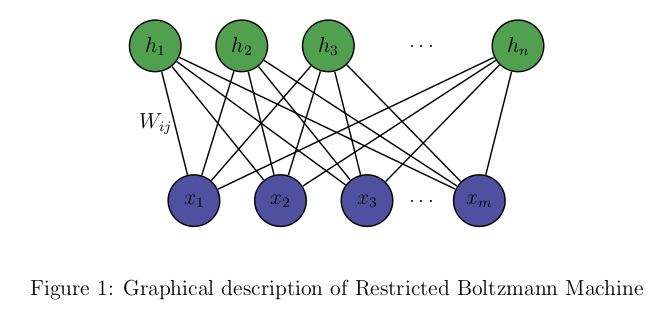
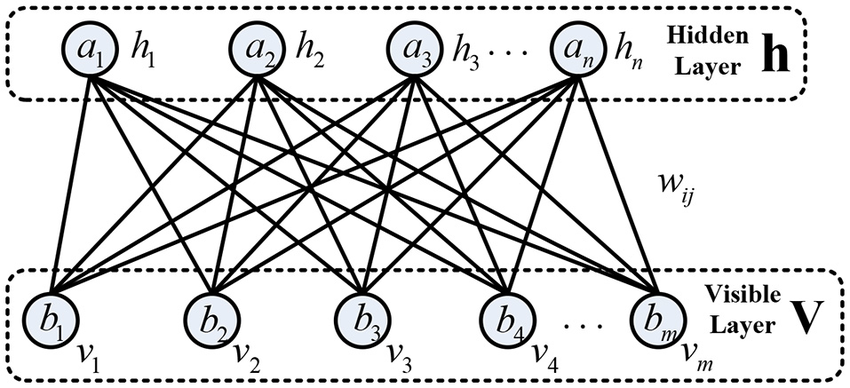
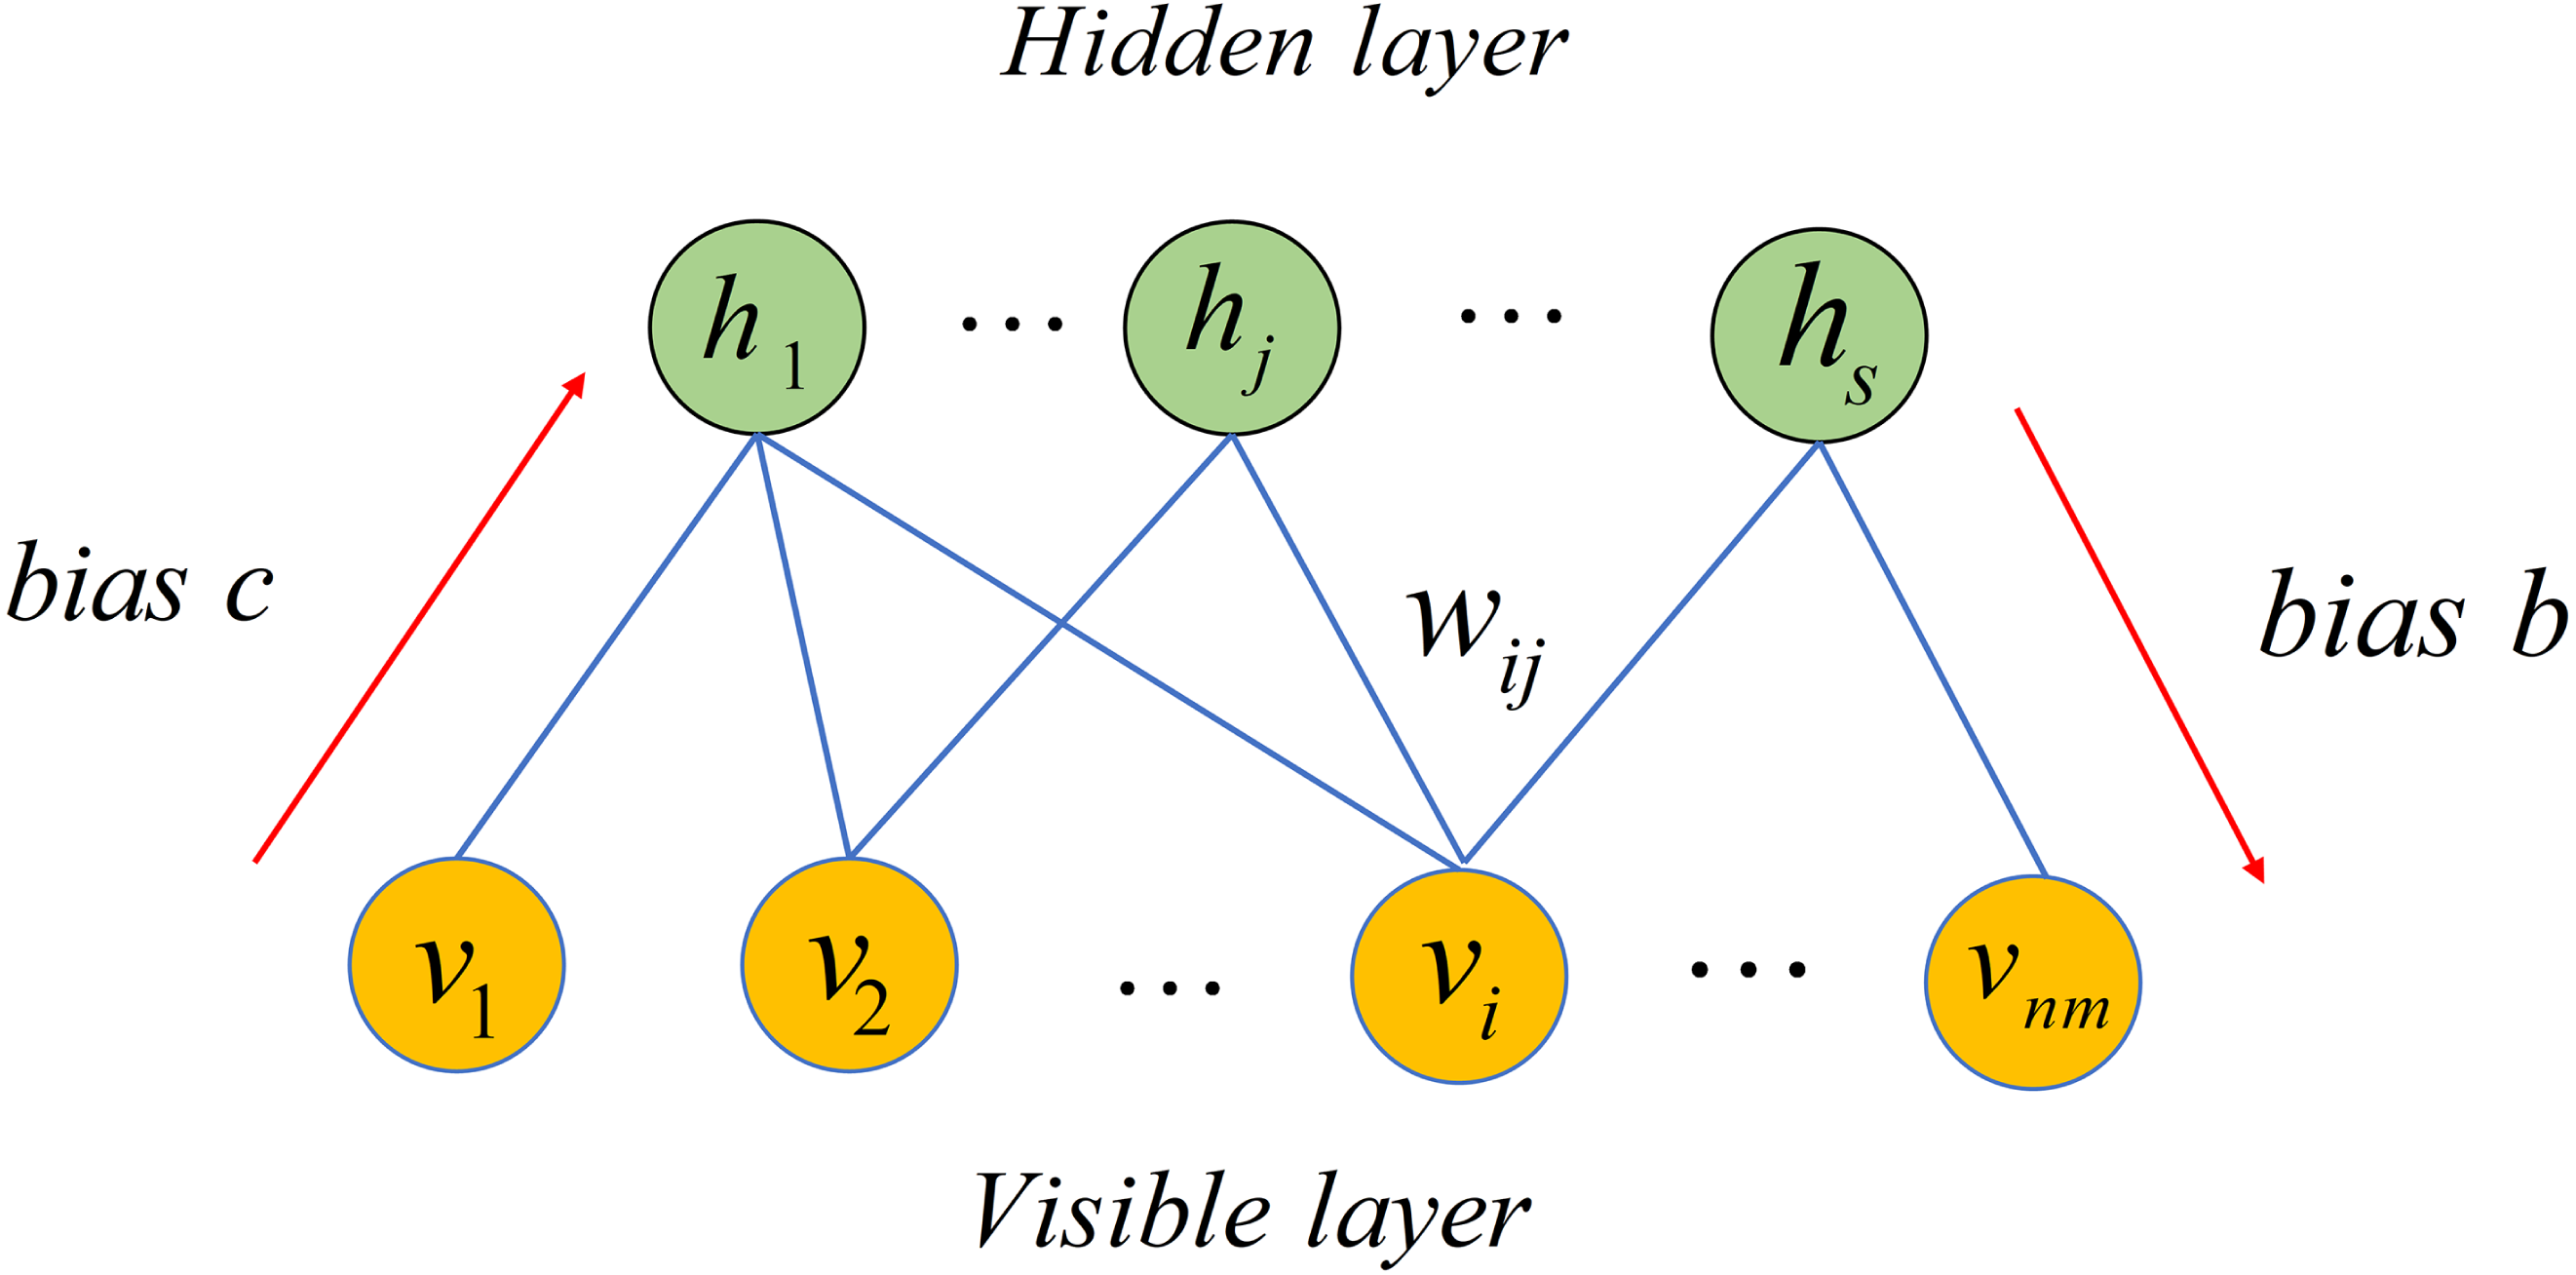
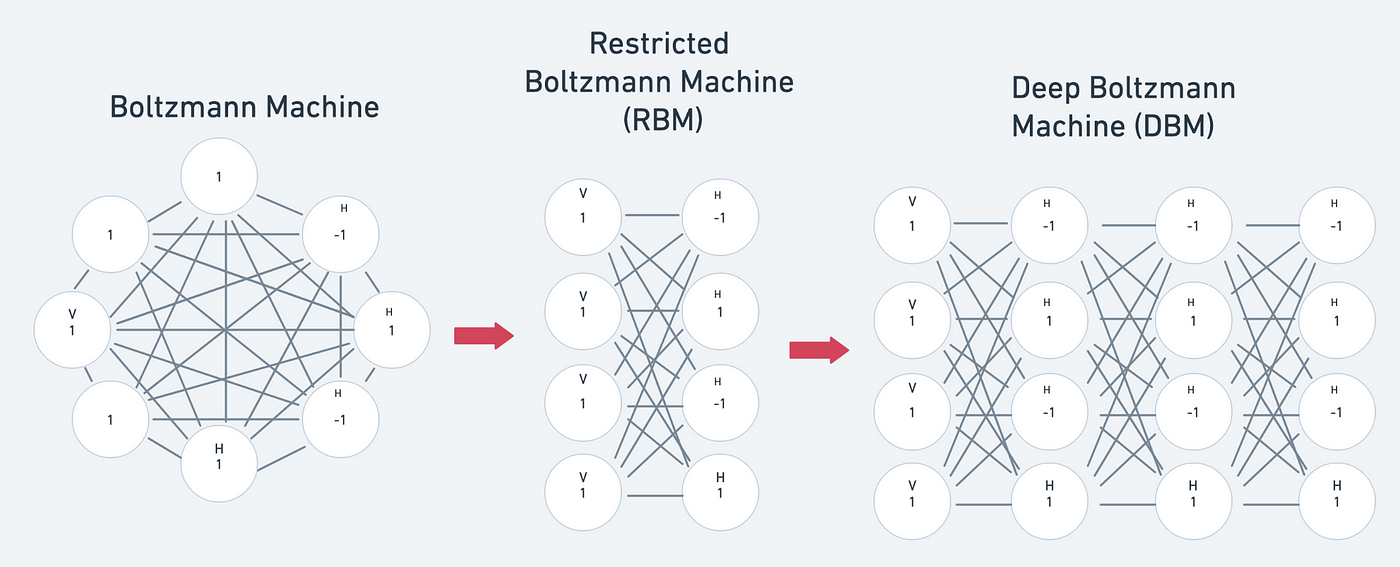
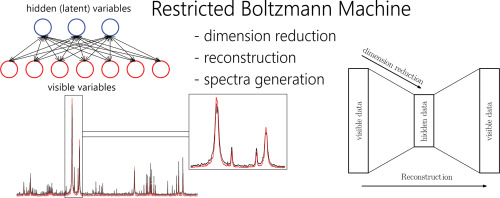
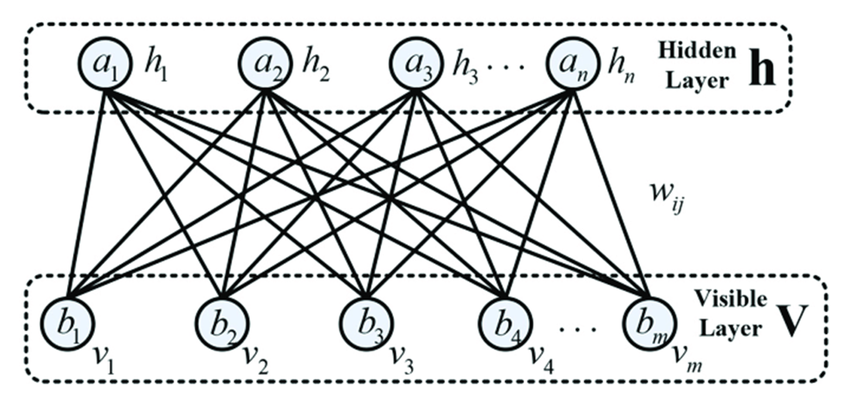
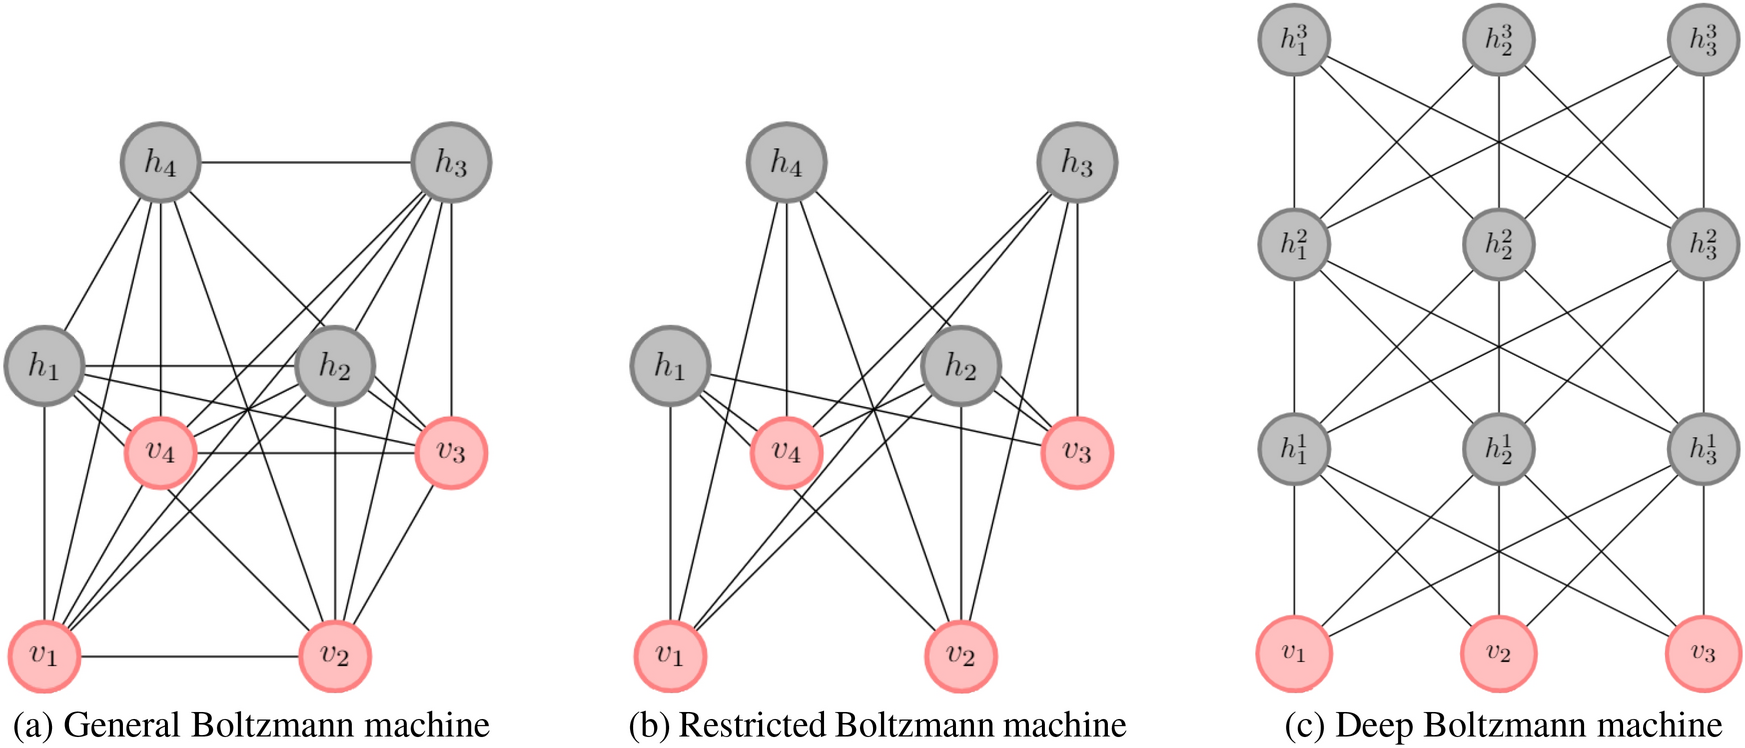
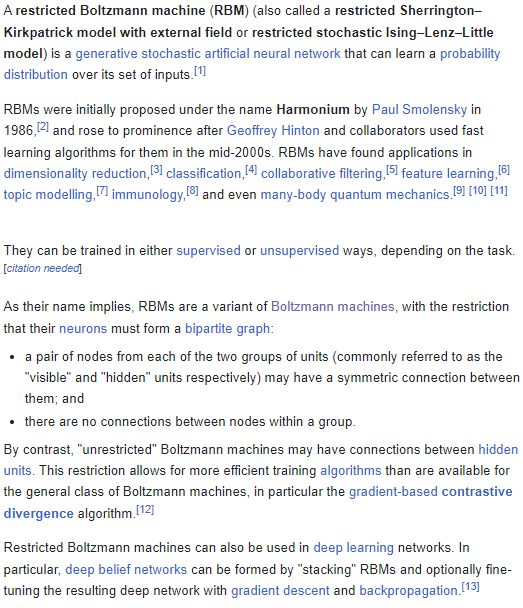
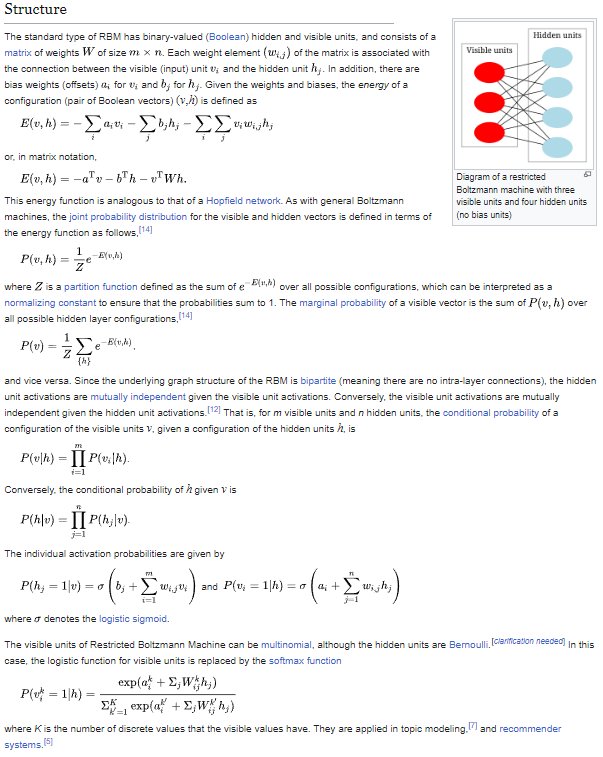
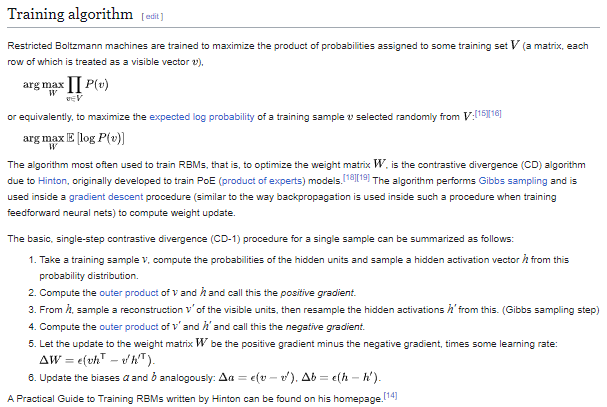
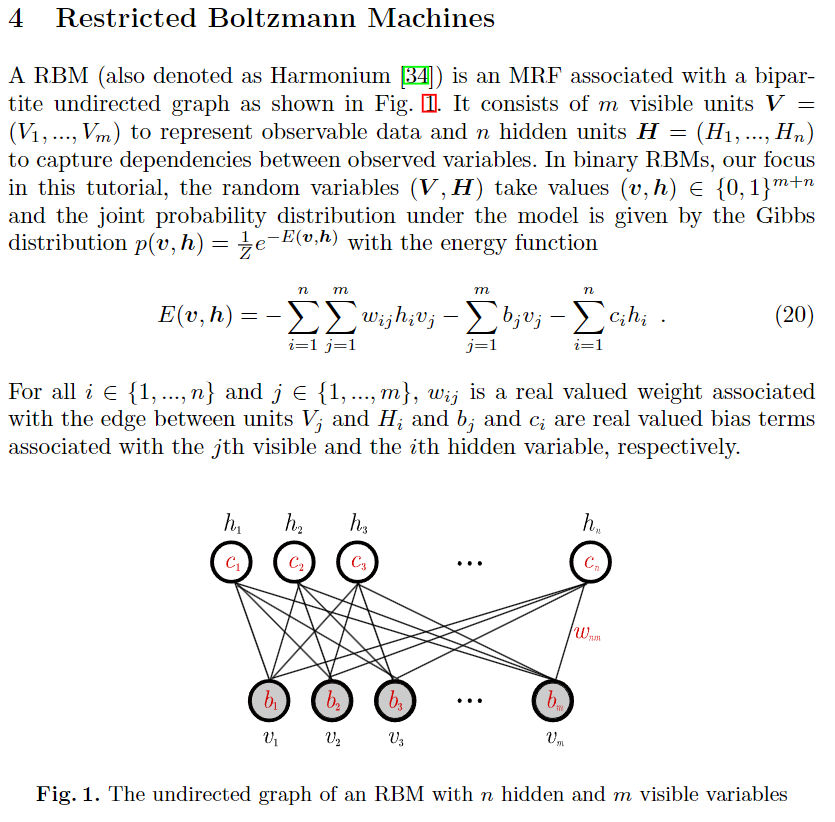
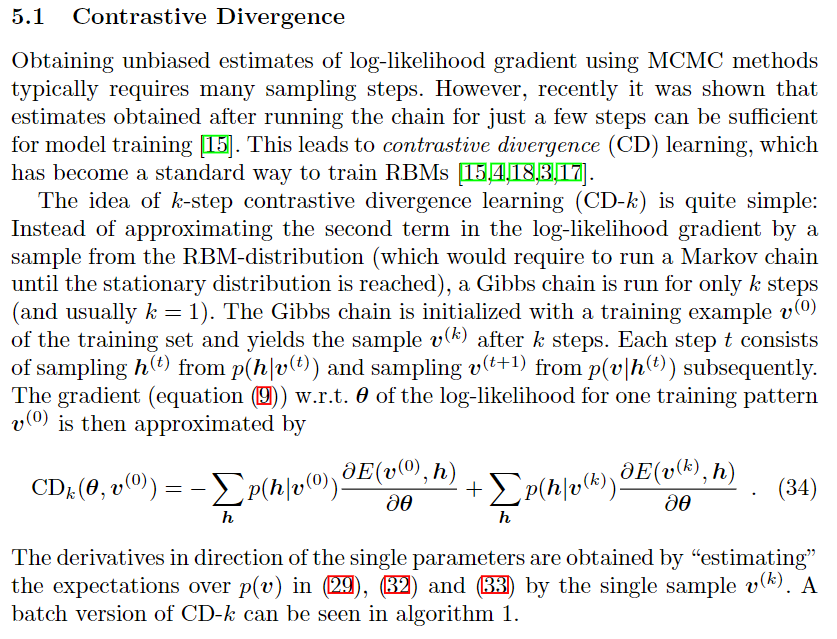
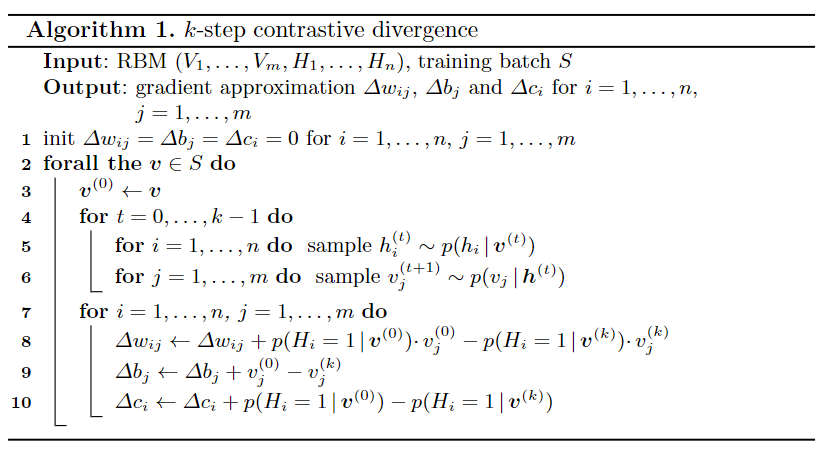

### <b>1. Importing/loading libraries</b>

In [107]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

### <b>2. Data preprocessing</b>

In [108]:
movies = pd.read_csv("ml-1m/movies.dat", sep = '::',
                     header = None, engine = "python",
                     encoding = "latin-1")
users = pd.read_csv("ml-1m/users.dat", sep = "::",
                     header = None, engine = "python",
                     encoding = "latin-1")
ratings = pd.read_csv("ml-1m/ratings.dat", sep = "::",
                      header = None, engine = "python",
                      encoding = "latin-1")

In [109]:
print(f"Movies: \n{movies}\n")

Movies: 
         0                                   1                             2
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
...    ...                                 ...                           ...
3878  3948             Meet the Parents (2000)                        Comedy
3879  3949          Requiem for a Dream (2000)                         Drama
3880  3950                    Tigerland (2000)                         Drama
3881  3951             Two Family House (2000)                         Drama
3882  3952               Contender, The (2000)                Drama|Thriller

[3883 rows x 3 columns]



In [110]:
print(f"Users: \n{users}\n")

Users: 
         0  1   2   3      4
0        1  F   1  10  48067
1        2  M  56  16  70072
2        3  M  25  15  55117
3        4  M  45   7  02460
4        5  M  25  20  55455
...    ... ..  ..  ..    ...
6035  6036  F  25  15  32603
6036  6037  F  45   1  76006
6037  6038  F  56   1  14706
6038  6039  F  45   0  01060
6039  6040  M  25   6  11106

[6040 rows x 5 columns]



In [111]:
print(f"Ratings: \n{ratings}\n")

Ratings: 
            0     1  2          3
0           1  1193  5  978300760
1           1   661  3  978302109
2           1   914  3  978301968
3           1  3408  4  978300275
4           1  2355  5  978824291
...       ...   ... ..        ...
1000204  6040  1091  1  956716541
1000205  6040  1094  5  956704887
1000206  6040   562  5  956704746
1000207  6040  1096  4  956715648
1000208  6040  1097  4  956715569

[1000209 rows x 4 columns]



#### <b>2.2 Preparing the training set and the test set</b>

In [112]:
training_set = pd.read_csv("ml-100k/u1.base", delimiter = "\t")
training_set = np.array(training_set, dtype = "int")

test_set = pd.read_csv("ml-100k/u1.test", delimiter = "\t")
test_set = np.array(test_set, dtype = "int")

print(f"Training set: \n{training_set}\n")
print(f"Test set: \n{test_set}\n")

Training set: 
[[        1         2         3 876893171]
 [        1         3         4 878542960]
 [        1         4         3 876893119]
 ...
 [      943      1188         3 888640250]
 [      943      1228         3 888640275]
 [      943      1330         3 888692465]]

Test set: 
[[        1        10         3 875693118]
 [        1        12         5 878542960]
 [        1        14         5 874965706]
 ...
 [      459       934         3 879563639]
 [      460        10         3 882912371]
 [      462       682         5 886365231]]



In [113]:
number_of_users = int(max(max(training_set[:, 0]), max(test_set[:, 0])))
number_of_movies = int(max(max(training_set[:, 1]), max(test_set[:, 1])))

print(f"Number of users: {number_of_users}")
print(f"Number of movies: {number_of_movies}")

Number of users: 943
Number of movies: 1682


In [114]:
def convert_data(data):
    new_data = []
    for id_users in range(1, number_of_users + 1):
        id_movies = data[:, 1][data[:, 0] == id_users]
        id_ratings = data[:, 2][data[:, 0] == id_users]
        ratings = np.zeros(number_of_movies)
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data

training_set = convert_data(training_set)
test_set = convert_data(test_set)

In [115]:
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

In [116]:
print(f"Training set: \n{training_set}\n")
print(f"Test set: \n{test_set}\n")

Training set: 
tensor([[0., 3., 4.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.]])

Test set: 
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])



In [117]:
training_set[training_set == 0] = -1
training_set[training_set == 1] = 0
training_set[training_set == 2] = 0
training_set[training_set >= 3] = 1
test_set[test_set == 0] = -1
test_set[test_set == 1] = 0
test_set[test_set == 2] = 0
test_set[test_set >= 3] = 1

print(f"Training set: \n{training_set}\n")

Training set: 
tensor([[-1.,  1.,  1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1.,  1., -1.,  ..., -1., -1., -1.]])



### <b>3. Creating/fitting The Neural Network Model</b>

#### <b>3.1 Creating The Neural Network Model</b>

In [118]:
class RestrictedBoltzmannMachine():
    def __init__(self, nv, nh):
        self.W = torch.randn(nh, nv)
        self.a = torch.randn(1, nh)
        self.b = torch.randn(1, nv)
        
    def sample_h(self, x):
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    
    def sample_v(self, y):
        wy = torch.mm(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    
    def train(self, v0, vk, ph0, phk):
        self.W += torch.mm(v0.t(), ph0).t() - torch.mm(vk.t(), phk).t()
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0 - phk), 0)

nv = len(training_set[0])
nh = 100
batch_size = 100
restricted_boltzmann_machine = RestrictedBoltzmannMachine(nv ,nh)

#### <b>3.2 Fitting The Neural Network Model</b>

In [119]:
number_of_epochs = 10
for epoch in range(1, number_of_epochs + 1):
    train_loss = 0
    s = 0.
    for id_user in range(0, number_of_users - batch_size, batch_size):
        vk = training_set[id_user:id_user+batch_size]
        v0 = training_set[id_user:id_user+batch_size]
        ph0, _ = restricted_boltzmann_machine.sample_h(v0)
        for k in range(10):
            _, hk = restricted_boltzmann_machine.sample_h(vk)
            _, vk = restricted_boltzmann_machine.sample_v(hk)
            vk[v0<0] = v0[v0<0]
        phk, _ = restricted_boltzmann_machine.sample_h(vk)
        restricted_boltzmann_machine.train(v0, vk, ph0, phk)
        train_loss += torch.mean(torch.abs(v0[v0>=0] - vk[v0>=0]))
        s += 1.
    print(f"epoch: {epoch}, loss: {train_loss/s}")

epoch: 1, loss: 0.3431801199913025
epoch: 2, loss: 0.25402167439460754
epoch: 3, loss: 0.24582844972610474
epoch: 4, loss: 0.24883539974689484
epoch: 5, loss: 0.25014179944992065
epoch: 6, loss: 0.24632641673088074
epoch: 7, loss: 0.24825024604797363
epoch: 8, loss: 0.24505466222763062
epoch: 9, loss: 0.24897214770317078
epoch: 10, loss: 0.2448357194662094


### <b>4. Evaluating the performance of the Neural Network Model</b>

In [121]:
test_loss = 0
s = 0.
for id_user in range(number_of_users):
    v = training_set[id_user:id_user+1]
    vt = test_set[id_user:id_user+1]
    if len(vt[vt>=0]) > 0:
        _, h = restricted_boltzmann_machine.sample_h(v)
        _, v = restricted_boltzmann_machine.sample_v(h)
        test_loss += torch.mean(torch.abs(vt[vt>=0] - v[vt>=0]))
        s += 1.
print(f"test loss: {test_loss/s}")

test loss: 0.25238966941833496
